In [0]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Project
# Copyright: Zhaoshuo Li, Ding Hao, Mingyi Zheng
!pip install tensorboardX visdom image_slicer
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
#from torchvision import transforms
import torchvision.transforms.functional as TF
from albumentations import *
import copy
import numpy as np
import random
from tensorboardX import SummaryWriter

#import transforms
from dataset import *
from visualization import *
from label_conversion import *
from dice_loss import *
from model_trainning import *
from model_from_ternaus import *
from deeplabv3p_resnet_super_label import SuperLabelDeepLabv3_plus
from unet import *

from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


In [0]:
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


# Seed pytorch and numpy and random

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pretrain_seed = 128

## Hyperparameters

In [0]:
train_batch_size = 10
validation_batch_size= 10
learning_rate = 0.001
num_epochs = 30
num_class = 12
num_superclasses = 2
weight_decay = 5e-4
super2sub = [[0,4,5,6,10],[1,2,3,7,8,9,11]]
num_filters = 64

In [0]:
#dice_loss = BatchWeightDICELoss()
weights = torch.ones((num_class,1)).to(device = device)
dice_loss = SuperLabelDICELoss(weights,_lambda=0.5) 
# dice_loss = DICELoss(weights)

## Visualization

In [0]:
# Initialize the visualization environment
writer = SummaryWriter()

## Super label deeplabv3+

In [0]:
#initialize model
model = SuperLabelDeepLabv3_plus(nInputChannels=3, n_super_classes = num_superclasses, n_classes=num_class, os=16, pretrained=True, _print=True,  super2sub = super2sub)
#model_dict = model.state_dict()
# pretrained_dict = torch.load("/mydrive/My Drive/Colab Notebooks/trained_albunet.pt")
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict and "final" not in k)}
# 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# 3. load the new state dict
# model.load_state_dict(model_dict)
# freeze the pretrained feature.
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.super_class_classifier.parameters():
#     param.requires_grad = True
# for param in model.final_classifier.parameters():
#     param.requires_grad = True
# model = AlbuNet(num_classes = num_class,num_filters = num_filters, pretrained = True, is_deconv = True)
model.to(device)

Constructing DeepLabv3+ model...
Number of classes: 12
Output stride: 16
Number of Input Channels: 3


SuperLabelDeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequent

## Optimizer and Scheduler and loss

In [0]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

## Baseline DeeplabV3+, pretrained, without augmentation.

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

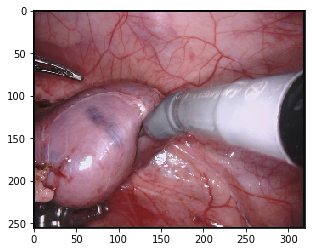

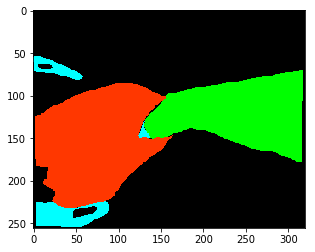

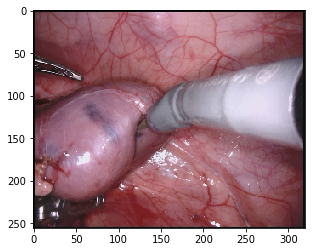

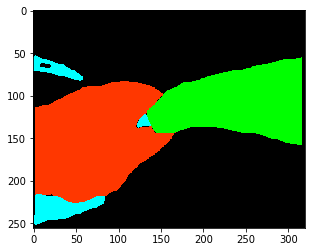

In [0]:
# define transform
image_aug = Compose([
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])
train_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "train", transform_image=image_aug)
validation_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "validation", transform_image=image_aug)
label_converter = LabelConverter(data_path = "/mydrive/My Drive/Colab Notebooks/data/")

# # show one example
img,label = (train_dataset[0]['img'],train_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

# show one example
img,label = (validation_dataset[0]['img'],validation_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

In [0]:
# intialize the dataloader
train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

## Start training

In [0]:
best_model_wts, best_acc = run_training(model,device,num_class,scheduler,optimizer,dice_loss,num_epochs,train_generator,train_dataset,validation_generator,validation_dataset,writer,"/mydrive/My Drive/Colab Notebooks/super_label_deeplabv3+_min.pt")

Training Started!

EPOCH 1 of 30

Training Loss: 0.8700
0 Class, True Pos 7869515.0, False Pos 3039192.0, False Neg 8896383.0, Num Pixel 16765898.0, Dice score 0.57
1 Class, True Pos 2671042.0, False Pos 1780378.0, False Neg 685340.0, Num Pixel 3356382.0, Dice score 0.68
2 Class, True Pos 1066873.0, False Pos 1963935.0, False Neg 618638.0, Num Pixel 1685511.0, Dice score 0.45
3 Class, True Pos 275633.0, False Pos 652989.0, False Neg 509428.0, Num Pixel 785061.0, Dice score 0.32
4 Class, True Pos 3545852.0, False Pos 3683134.0, False Neg 2759235.0, Num Pixel 6305087.0, Dice score 0.52
5 Class, True Pos 2352752.0, False Pos 2994743.0, False Neg 1923407.0, Num Pixel 4276159.0, Dice score 0.49
6 Class, True Pos 0.0, False Pos 15553.0, False Neg 135555.0, Num Pixel 135555.0, Dice score 0.00
7 Class, True Pos 185.0, False Pos 55122.0, False Neg 193239.0, Num Pixel 193424.0, Dice score 0.00
8 Class, True Pos 0.0, False Pos 105335.0, False Neg 964.0, Num Pixel 964.0, Dice score 0.00
9 Class, T

In [0]:
## load best model weights
model.load_state_dict(best_model_wts)
## save model
torch.save(model.state_dict(), '/mydrive/My Drive/Colab Notebooks/super_label_deeplabv3+_min.pt')

In [0]:
print(best_acc)

tensor(0.7767)


# Data Augmentation

In [0]:
train_batch_size = 10
validation_batch_size= 10
learning_rate = 0.001
num_epochs = 30*2
num_class = 12
num_superclasses = 2
weight_decay = 5e-4
super2sub = [[0,4,5,6,10],[1,2,3,7,8,9,11]]
num_filters = 64

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [0]:
#initialize model
model = SuperLabelDeepLabv3_plus(nInputChannels=3, n_super_classes = num_superclasses, n_classes=num_class, os=16, pretrained=True, _print=True,  super2sub = super2sub)
#model_dict = model.state_dict()
# pretrained_dict = torch.load("/mydrive/My Drive/Colab Notebooks/trained_albunet.pt")
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict and "final" not in k)}
# 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# 3. load the new state dict
# model.load_state_dict(model_dict)
# freeze the pretrained feature.
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.super_class_classifier.parameters():
#     param.requires_grad = True
# for param in model.final_classifier.parameters():
#     param.requires_grad = True
# model = AlbuNet(num_classes = num_class,num_filters = num_filters, pretrained = True, is_deconv = True)
model.to(device)

Constructing DeepLabv3+ model...
Number of classes: 12
Output stride: 16
Number of Input Channels: 3


SuperLabelDeepLabv3_plus(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequent

In [0]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

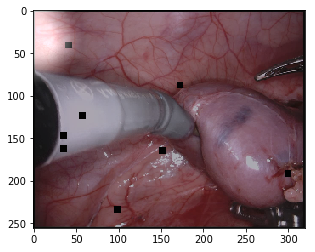

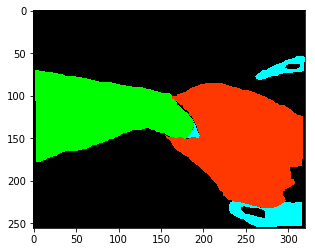

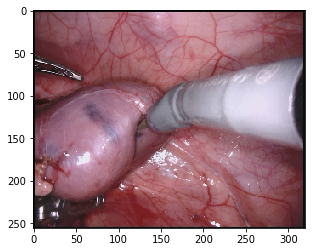

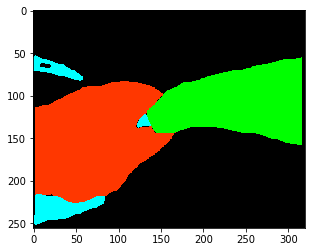

In [0]:
# define transform
train_both_aug = Compose([
    Cutout(num_holes=8,p=0.5),
    OneOf([
        ShiftScaleRotate(rotate_limit=15,p=0.5),
        HorizontalFlip(p=0.8),
    ])
])
train_image_aug = Compose([
    OneOf([
        RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.5,p=0.7),
        RandomGamma(p=0.7),                    
    ]),
    HueSaturationValue(p=0.7),
    MotionBlur(blur_limit=7,p=0.7),
    RandomSpotlight(p=0.7),
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])

val_image_aug = Compose([
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])
train_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "train", transform_both=train_both_aug, transform_image=train_image_aug)
validation_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "validation", transform_image=val_image_aug)
label_converter = LabelConverter(data_path = "/mydrive/My Drive/Colab Notebooks/data/")

# show one example
img,label = (train_dataset[0]['img'],train_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

# show one example
img,label = (validation_dataset[0]['img'],validation_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

In [0]:
# intialize the dataloader
train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

In [0]:
best_model_wts, best_acc = run_training(model,device,num_class,scheduler,optimizer,dice_loss,num_epochs,train_generator,train_dataset,validation_generator,validation_dataset,writer,'/mydrive/My Drive/Colab Notebooks/super_label_deeplabv3+_aug.pt')

Training Started!

EPOCH 1 of 60

Training Loss: 0.9244
0 Class, True Pos 6287388.0, False Pos 3054810.0, False Neg 10438320.0, Num Pixel 16725708.0, Dice score 0.48
1 Class, True Pos 2442208.0, False Pos 2188873.0, False Neg 917596.0, Num Pixel 3359804.0, Dice score 0.61
2 Class, True Pos 1114908.0, False Pos 2383270.0, False Neg 569000.0, Num Pixel 1683908.0, Dice score 0.43
3 Class, True Pos 9688.0, False Pos 207148.0, False Neg 779482.0, Num Pixel 789170.0, Dice score 0.02
4 Class, True Pos 2856011.0, False Pos 5066302.0, False Neg 3456159.0, Num Pixel 6312170.0, Dice score 0.40
5 Class, True Pos 2210231.0, False Pos 3532140.0, False Neg 2074526.0, Num Pixel 4284757.0, Dice score 0.44
6 Class, True Pos 110.0, False Pos 21226.0, False Neg 135809.0, Num Pixel 135919.0, Dice score 0.00
7 Class, True Pos 46.0, False Pos 56284.0, False Neg 195901.0, Num Pixel 195947.0, Dice score 0.00
8 Class, True Pos 0.0, False Pos 97840.0, False Neg 959.0, Num Pixel 959.0, Dice score 0.00
9 Class, Tr

In [0]:
## load best model weights
model.load_state_dict(best_model_wts)
## save model
torch.save(model.state_dict(), '/mydrive/My Drive/Colab Notebooks/super_label_deeplabv3+_min_aug.pt')

In [0]:
print(best_acc)

tensor(0.7847)
